In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif, RFE, SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
random_state = 505

In [3]:
df_all = pd.read_csv('../data/dataset_with_features_ee3_200_20.csv')
df_all.head()

,Covert,Mean,Std,Median,Skew,Kurtosis,NumberUniqueValues,ModeFreq,NumberModesKDE,NumberModesPareto,...,1stLocOfMinimum,RatioBeyond2.5,ValueCounts_4,ValueCounts_6,ValueCounts_9,ValueCounts_43,ValueCounts_44,RMSE,MAE,SymmetricTest
0,1,20.204,9.805,19.384,0.292,-0.795,40,0.060,2,2,...,0.895,0.0,2,7,6,0,0,9.780,8.160,39.265
1,1,20.441,10.089,19.795,0.252,-0.901,39,0.060,1,0,...,0.795,0.0,2,7,8,0,0,10.064,8.465,39.439
2,1,20.073,10.071,19.336,0.262,-0.937,39,0.060,3,0,...,0.695,0.0,2,8,8,0,0,10.046,8.455,38.599
3,1,20.003,10.308,18.600,0.348,-0.874,41,0.060,3,1,...,0.595,0.0,2,8,11,1,0,10.283,8.617,39.665
4,1,20.399,10.436,18.635,0.337,-0.956,40,0.055,3,1,...,0.495,0.0,2,6,11,1,0,10.410,8.757,39.304


In [4]:
nth_columns = ['Mean2th', 'Mean3th', 'Mean5th', 'Mean10th', 'Unique2th', 'Unique3th',
               'Unique5th', 'Unique10th', 'Max2th', 'Max3th', 'Max5th', 'Max10th',
               'Min2th', 'Min3th', 'Min5th', 'Min10th', 'Max_difference2th',
               'Max_difference3th', 'Max_difference5th', 'Max_difference10th',
               'Autocorrelation_8', 'Autocorrelation_16', 'Autocorrelation_24',
               'Autocorrelation_40', 'C3_8', 'C3_16', 'C3_24', 'C3_40', 'CountAbove35', 'CountAbove43',
               'ValueCounts_4', 'ValueCounts_6', 'ValueCounts_9', 'ValueCounts_43', 'ValueCounts_44']

df = df_all.loc[:, ~df_all.columns.isin(nth_columns)]

# Описание признаков

Все признаки вычисляются для окна - массива чисел размера `window_size`.

$*$ - перед вычислением статистики значения округлены до целых чисел.
1. **mean** - среднее
2. **std** - стандартное отклонение
3. **median** - медиана
4. **skewness** - коэффициент ассиметрии
5. **kurtosis** - коэффициент эксцесса
6. $*$ **number unique values** - кол-во уникальных значений
7. $*$ **mode frequency** - частота, с котором встречается мода массива
8. **number of modes, kde** - число мод распределения, определенное с помощью Kernel Density Estimation
9. $*$ **number of modes, pareto** - число мод распределения, определенное с помощью метода Парето
10. **mean Nth** `for N in {2, 3, 5, 10}` - среднее массива, составленного из N-ых элементов исходного массива
11. **unique Nth** `for N in {2, 3, 5, 10}` - число уникальных элементов в массиве, составленного из N-ых элементов исходного массива
12. **max Nth** `for N in {2, 3, 5, 10}` - максимум массива, составленного из N-ых элементов исходного массива
13. **min Nth** `for N in {2, 3, 5, 10}` - минимум массива, составленного из N-ых элементов исходного массива
14. **max difference Nth** `for N in {2, 3, 5, 10}` - `max Nth - min Nth`
15. **sum** - сумма элементов массива
16. **autocorrelation** - коэффициент автокорреляции для лагов `8, 16, 24, 40`
17. **sum of autocorr coeffs** - сумма коэффициентов автокорреляции для лагов `8, 16, 24, 40`
18. **max of autocorr coeffs** - максимум из коэффициентов автокорреляции для лагов `8, 16, 24, 40`
19. $*$ **berk method** - метод оценки вероятности наличия скрытого канала на основе частоты среднего значения
20. **average distribution width** - средняя ширина распределения, рассчитанная с помощью Kernel Density Estimation
21. **runs test** - Wald–Wolfowitz runs test
22. **sign test** - знаковый тест, нулевая гипотеза - элементы получены независимо
23. **e-similarity** - эпсилон-близость
24. $*$ **entropy** - величина энтропии
25. **approximate entropy** - тоже энтропия, вычисленная с помощью `nolds.sampen`
26. $*$ **gini** - величина критерия Джини
27. $*$ **kolmogorov complexity** - Колмогоровская сложность строки, сжатие `zlib`
28. **hurst exponent** - [показатель Хёрста](https://ru.wikipedia.org/wiki/Показатель_Хёрста)
29. **regularity tests** - мера регулярности (в работе Cabuk 2004 используется Std и Std, а в работе Archibald 2014 предложено использовать и другие функции) [Std, Skew, Kurtosis] x [Mean, Std, Median]
30. **haar cD1** - коэффициент вейвлет-преобразования (Mou 2012)
31. **ADF test** - [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test)
32. **benford correlation** - [корреляция Бенфорда](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.benford_correlation), реализация как в библиотеке `tsfresh`
33. **C3** - [мера нелинейности C3](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.c3) из `tsfresh` для лагов `8, 16, 24, 40`
34. **complexity estimation** - [оценка сложности распределения](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.cid_ce) из `tsfresh`
35. **count above** - количество элементов, значение которых больше порога. В качестве порога 35, 43
36. **1st loc of max** - индекс первого появления максимума в массиве (из `tsfresh`)
37. **1st loc of min** - индекс первого появления минимума в массиве (из `tsfresh`)
38. **ratio beyond r** - количество элементов массива, не попадающих в интервал $\mu ± 2.5\sigma$ (из `tsfresh`)
39. $*$ **value counts** - количество элементов, равных заданной величине. Используется `4, 6, 9, 43, 44`
40. **rmse** - root mean squared error (между элементами и средним)
41. **mae** - mean absolute error (между элементами и медианой)
42. **symmetric test** - $max(A) - min(A) - |mean(A) - median(A)|$ 

# Подготовка данных

In [5]:
covert = df[df['Covert'] == 1]

In [6]:
overt = df[df['Covert'] == 0].reset_index(drop=True)

In [7]:
hold_size = 500
train_size_covert = 1000
train_size_overt = 1000

Оставим hold часть для финальной оценки качества моделей

In [8]:
df_hold = pd.concat((covert[-hold_size:], overt[-hold_size:]), ignore_index=True, sort=False)

In [9]:
X_hold = df_hold.drop(['Covert'], axis=1)
y_hold = df_hold['Covert']

In [10]:
np.random.seed(random_state)
covert_indexes = np.random.randint(0, df.shape[0] // 2 - hold_size * 2, train_size_covert)

In [11]:
np.random.seed(random_state // 2)
overt_indexes = np.random.randint(0, df.shape[0] // 2 - hold_size * 2, train_size_overt)

In [12]:
df_train = pd.concat((covert.loc[covert_indexes], overt.loc[overt_indexes]), ignore_index=True, sort=False)

** Почему в качестве метрики качества классификации выбрана F1-мера? **

Потому что она учитывает как полноту, так и точность обнаружения скрытого канала, следовательно позволяет лучше оценить качество классификации.

In [13]:
def calculate_cross_val_score(estimator, X, y):
    """ Функция вычисляет среднее значение F1-меры при кросс-валидации с 5 фолдами """
    return np.mean(cross_val_score(estimator, X, y, scoring='f1',
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)))

In [14]:
results_features = pd.DataFrame(df.columns[1:], columns=['feature_name'])
results_features['All features'] = 1

In [15]:
results_models = pd.DataFrame(columns=['DecisionTree', 'SVM', 'RF', 'Mean'])

# Бейзлайн
Первая версия - используются все признаки. Качество предсказания проверяется с помощью функции `calculate_cross_val_score` для трёх моделей. Обоснование их выбора:
- `DecisionTreeClassifier` - классическое решающее дерево для классификации. Модель выбрана из-за скорости работы и интерпретируемости.
- `SVM` - метод опорных векторов. Среди линейных моделей выбран именно он, так как показал лучшие результаты на кросс-валидации и встречается в большинстве работ по обнаружению скрытых каналов у других авторов.
- `RandomForestClassifier` - случайный лес. Выбран в качестве более "сложной" модели, так как показал высокие результаты на кросс-валидации. Так же была попытка использовать разные вариации градиентного бустинга, однако из-за небольшого размера выборки модели сильно переобучались, и был сделан выбор в пользу более простых вариантов.

Все модели используются с параметрами по умолчанию и фиксированным `random_state`.

### Decision Tree

In [16]:
X = df_train.drop(['Covert'], axis=1)
y = df_train['Covert']

In [17]:
tree = DecisionTreeClassifier(random_state=random_state)
dt_baseline = calculate_cross_val_score(tree, X, y)
print(dt_baseline)

0.8212697688254064


#### Визуализация дерева

In [18]:
fitted_tree = DecisionTreeClassifier(random_state=random_state).fit(X, y)

### SVM

In [20]:
standard_scaler = StandardScaler().fit(X)

In [21]:
X_std_scaled = pd.DataFrame(standard_scaler.transform(X), columns=X.columns)

In [22]:
svc = SVC(random_state=random_state)
svm_baseline = calculate_cross_val_score(svc, X_std_scaled, y)
print(svm_baseline)

0.8879795984352166


### RF

In [23]:
rf = RandomForestClassifier(random_state=random_state)
rf_baseline = calculate_cross_val_score(rf, X, y)
print(rf_baseline)

0.8865590470906186


### Функция для тестирования метода отбора признаков

In [24]:
def evaluate_feature_selection_method(features_to_use, method_name):
    """ 
    Функция, тестирующая качество работы метода отбора признаков
    
    :param features_to_use: list, отобранные методом признаки
    :param method_name: str, название метода отбора, которое будет записано в results_models
    """
    
    cross_val_scores = []
    
    print('Method:', method_name)
    tree = DecisionTreeClassifier(random_state=random_state)
    dt_score = round(calculate_cross_val_score(tree, X[features_to_use], y), 3)
    cross_val_scores.append(dt_score)
    print('Decision Tree:', dt_score)
    
    svm = SVC(random_state=random_state)
    svm_score = round(calculate_cross_val_score(svm, X_std_scaled[features_to_use], y), 3)
    cross_val_scores.append(svm_score)
    print('SVM:', svm_score)
    
    rf = RandomForestClassifier(random_state=random_state)
    rf_score = round(calculate_cross_val_score(rf, X[features_to_use], y), 3)
    cross_val_scores.append(rf_score)
    print('RF:', rf_score)
    
    mean = round(np.mean(cross_val_scores), 3)
    print('Mean:', mean)
    print('Save results into results_models dataframe')
    results_models.loc[method_name] = cross_val_scores + [mean]

Сохранение бейзлайн-результатов

In [25]:
scores_baseline = [dt_baseline, svm_baseline, rf_baseline]
results_models.loc['All features'] = np.round(scores_baseline + [np.mean(scores_baseline)], 3)

# Отбор признаков

## Unsupervised methods
Анализ корреляции между признаками

In [26]:
corr = X.corr()

<AxesSubplot:>

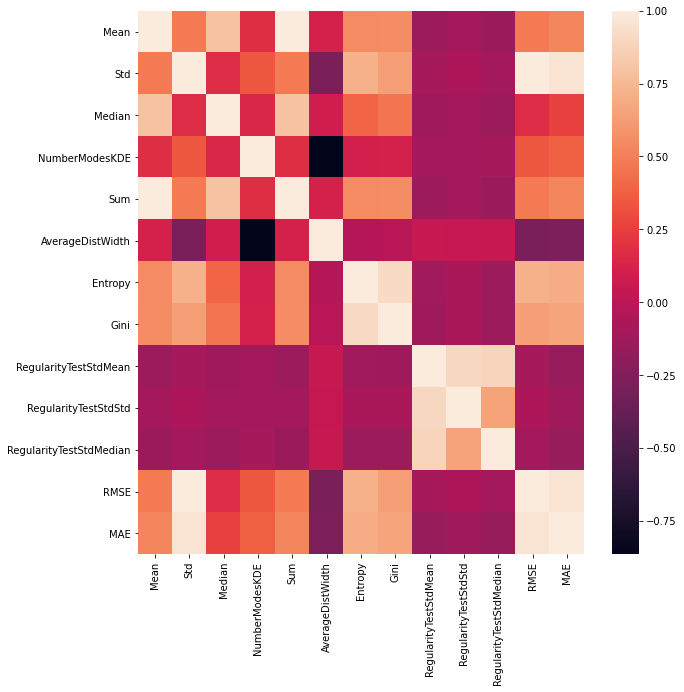

In [27]:
plt.subplots(figsize=(10, 10))

sns.heatmap(corr.loc[np.sum(np.abs(corr) > 0.8) > 1, np.sum(np.abs(corr) > 0.8) > 1])

Вывод пар признаков, чья линейная корреляция по модулю > 0.85

In [28]:
threshold = 0.85
features = corr.columns

for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        corr_coeff = corr.iloc[i, j]
        if abs(corr_coeff) > threshold:
            print(f'{features[i]} and {features[j]} - {np.round(corr_coeff, 3)}')

Mean and Sum - 1.0
Std and RMSE - 1.0
Std and MAE - 0.957
NumberModesKDE and AverageDistWidth - -0.865
Entropy and Gini - 0.919
RegularityTestStdMean and RegularityTestStdStd - 0.904
RegularityTestStdMean and RegularityTestStdMedian - 0.885
RMSE and MAE - 0.957


Удаляются признаки так, чтобы не осталось сильнокоррелирющих пар

In [29]:
corr_method_to_delete = {
    'Sum',
    'RMSE',
    'MAE',
    'AverageDistWidth',
    'Gini',
    'RegularityTestStdMean'
}

In [30]:
results_features['Correlation'] = (~results_features.feature_name.isin(corr_method_to_delete)) * 1

In [31]:
evaluate_feature_selection_method(list(set(X.columns) - corr_method_to_delete), 'Correlation')

Method: Correlation
Decision Tree: 0.824
SVM: 0.89
RF: 0.889
Mean: 0.868
Save results into results_models dataframe


In [33]:
corr_ = X.loc[:, ~X.columns.isin(corr_method_to_delete)].corr()
threshold = 0.85
features = corr_.columns

for i in range(corr_.shape[0]):
    for j in range(i + 1, corr_.shape[0]):
        corr_coeff = corr_.iloc[i, j]
        if abs(corr_coeff) > threshold:
            print(f'{features[i]} and {features[j]} - {np.round(corr_coeff, 3)}')

## Filter methods
Методы, использующие статистические критерии, в которых участвуют признаки и таргет 

In [34]:
features_to_use = list(set(X.columns) - set(corr_method_to_delete))

### 1. ANOVA F-test

In [35]:
anova = f_classif(X_std_scaled[features_to_use], y)

In [36]:
anova_scores = {feature: score for score, feature in sorted(zip(anova[0], features_to_use), 
                                                            key=lambda x: x[0])}

In [37]:
results_features['Anova'] = results_features.feature_name.map(anova_scores).fillna(0)

### 2. Kendall Tau test

In [38]:
kendall_corrs = []

for feature in features_to_use:
    kendall_corrs.append(kendalltau(X[feature], y).correlation)

In [39]:
kendall_scores = {feature: score for score, feature in sorted(zip(np.abs(kendall_corrs), features_to_use), 
                                                              key=lambda x: x[0])}

results_features['Kendall'] = results_features.feature_name.map(kendall_scores).fillna(0)

### 3. Chi2

In [40]:
minmax = MinMaxScaler().fit(X)
X_minmax = pd.DataFrame(minmax.transform(X), columns=X.columns)

In [41]:
chi = chi2(X_minmax[features_to_use], y)

In [42]:
chi_scores = {feature: score for score, feature in sorted(zip(chi[0], features_to_use), 
                                                          key=lambda x: x[0])}

results_features['Chi2'] = results_features.feature_name.map(chi_scores).fillna(0)

## Feature importances
Группа методов, использующих при отборе вес, который признаки приобретают в процессе обучения конкретной модели

### 1. Linear coefficients
У линейных моделей значимость признака определяется весом коэффициента, соответсвующего данному признаку. В качестве линейной модели классификации используется логистическая регрессия с L1-регуляризацией, которая зануляет веса незначимых признаков.

In [43]:
lr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')

In [44]:
lr.fit(X_std_scaled[features_to_use], y)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [45]:
weights = lr.coef_

In [46]:
linear_scores = {feature: score for score, feature in sorted(zip(np.abs(weights[0]), features_to_use), 
                                                          key=lambda x: x[0])}

results_features['Linear'] = results_features.feature_name.map(linear_scores).fillna(0)

### 2. Decision Tree FE
У решающих деревьев feature importance определяется как суммарное величина на которую этот признак уменьшил значение критерия Джини при расщеплении. 

In [47]:
fitted_tree = DecisionTreeClassifier().fit(X[features_to_use], y)

34


Text(0.5, 1.0, 'Decision Tree (baseline) Feature Importance')

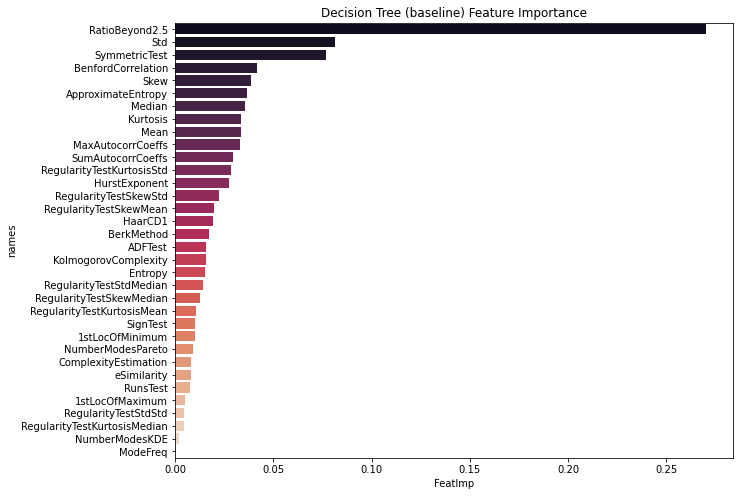

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))

feat_imp = pd.DataFrame({
    'names': X[features_to_use].columns,
    'FeatImp': fitted_tree.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0]
print(feat_imp.shape[0])
dt_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('Decision Tree (baseline) Feature Importance')

In [49]:
tree_scores = {feature: score for score, feature in sorted(zip(fitted_tree.feature_importances_, 
                                                               features_to_use), 
                                                           key=lambda x: x[0])}

results_features['DT FE'] = results_features.feature_name.map(tree_scores).fillna(0)

### 3. Random Forest FE 
У случайного леса feature importance вычисляется аналогично решающему дереву, только величина для каждого признака суммируется по всем деревьям в лесе.

In [50]:
rf.fit(X[features_to_use], y)

RandomForestClassifier(random_state=505)

31


Text(0.5, 1.0, 'RF (baseline) Feature Importance')

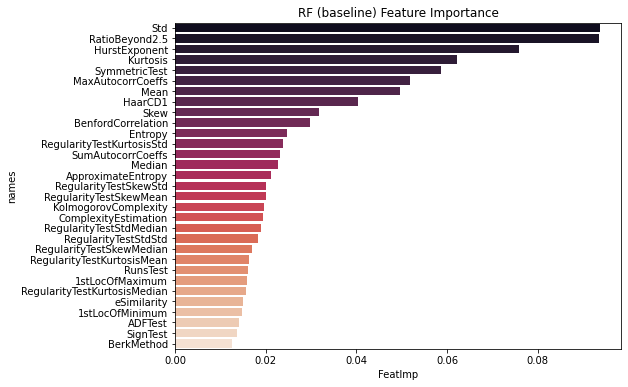

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

feat_imp = pd.DataFrame({
    'names': features_to_use,
    'FeatImp': rf.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0.01]
print(feat_imp.shape[0])
rf_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('RF (baseline) Feature Importance')

In [52]:
rf_scores = {feature: score for score, feature in sorted(zip(rf.feature_importances_, 
                                                             features_to_use), 
                                                         key=lambda x: x[0])}

results_features['RF FE'] = results_features.feature_name.map(rf_scores).fillna(0)

Подбор оптимальных гиперпараметров для `RandomForestClassifier`

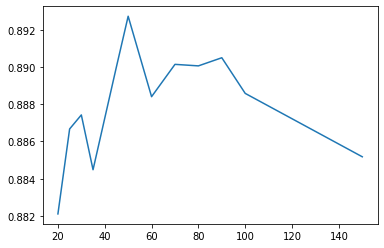

In [54]:
ns = [20, 25, 30, 35, 45, 50, 60, 70, 80, 90, 100, 150]
cv_scores = []
for n in ns:
    rf_ = RandomForestClassifier(n_estimators=n, random_state=random_state)
    cv_scores.append(calculate_cross_val_score(rf_, X[features_to_use], y))
    
plt.plot(ns, cv_scores)

In [59]:
rf_parameters = {
    'max_features': [7, 8, 9, 10, 15, 20],
    'max_depth': [None, 8, 10, 12, 13, 14, 15, 16, 17, 20],
}

In [60]:
rgs_rf = RandomizedSearchCV(RandomForestClassifier(n_estimators=50, random_state=random_state, n_jobs=-1),
                        rf_parameters, 
                        n_iter=100,
                        scoring='f1',
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state))

In [61]:
rgs_rf.fit(X[features_to_use], y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=505, shuffle=True),
                   estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                                    random_state=505),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 8, 10, 12, 13, 14,
                                                      15, 16, 17, 20],
                                        'max_features': [7, 8, 9, 10, 15, 20]},
                   scoring='f1')

In [62]:
rgs_rf.best_score_, rgs_rf.best_params_

(0.8908563573994991, {'max_features': 9, 'max_depth': 14})

33


Text(0.5, 1.0, 'RF (tuned) Feature Importance')

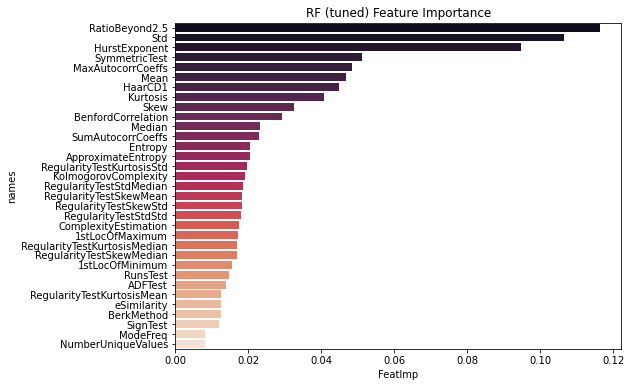

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

feat_imp = pd.DataFrame({
    'names': features_to_use,
    'FeatImp': rgs_rf.best_estimator_.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0.007]
print(feat_imp.shape[0])
rgs_rf_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('RF (tuned) Feature Importance')

In [64]:
rf_tuned_scores = {feature: score for score, feature in sorted(zip(rgs_rf.best_estimator_.feature_importances_, 
                                                                   features_to_use), 
                                                               key=lambda x: x[0])}

results_features['RF Tuned FE'] = results_features.feature_name.map(rf_tuned_scores).fillna(0)

### 4. XGBoost FE
Feature importance определяется аналогично случайному лесу

In [65]:
gb = GradientBoostingClassifier(random_state=random_state)

In [66]:
gb.fit(X[features_to_use], y)

GradientBoostingClassifier(random_state=505)

16


Text(0.5, 1.0, 'XGBoost Feature Importance')

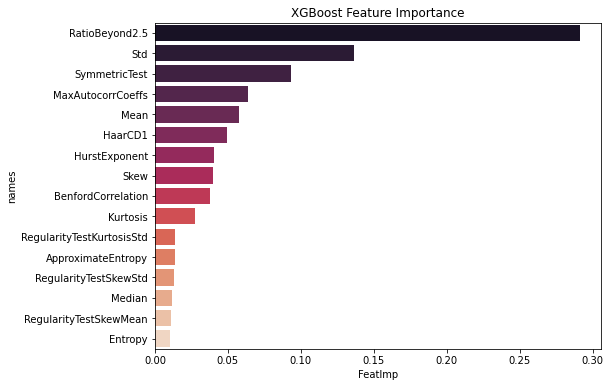

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

feat_imp = pd.DataFrame({
    'names': features_to_use,
    'FeatImp': gb.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0.01]
print(feat_imp.shape[0])
gb_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('XGBoost Feature Importance')

In [68]:
gb_scores = {feature: score for score, feature in sorted(zip(gb.feature_importances_, 
                                                             features_to_use), 
                                                         key=lambda x: x[0])}

results_features['XGBoost FE'] = results_features.feature_name.map(gb_scores).fillna(0)

### Permutation Importance
Permutation Importance - метод, который определяет важность признаков следующим образом: измеряется на сколько ухудшается качество модели, если все значения данного признака перемешать случайным образом. Чем важнее признак, тем сильнее ухудшится качество модели. 

In [69]:
r2 = permutation_importance(fitted_tree, X[features_to_use], y, scoring='f1', n_repeats=5)

In [70]:
pe_scores = {feature: score for score, feature in sorted(zip(r2.importances_mean, 
                                                             features_to_use), 
                                                         key=lambda x: x[0])}

results_features['Permutation Importance'] = results_features.feature_name.map(pe_scores).fillna(0)

### RFE
Recursive Feature Elimination использует подход рекурсивного уменьшения количества признаков до тех пор, пока не будет достигнуто необходимое количество.

In [71]:
rfe = RFE(estimator=DecisionTreeClassifier(max_depth=5, random_state=random_state), n_features_to_select=15)
rfe.fit(X[features_to_use], y)

RFE(estimator=DecisionTreeClassifier(max_depth=5, random_state=505),
    n_features_to_select=15)

In [72]:
rfe_scores = {feature: score for score, feature in sorted(zip(rfe.support_ * 1, 
                                                              features_to_use), 
                                                          key=lambda x: x[0])}

results_features['RFE'] = results_features.feature_name.map(rfe_scores).fillna(0)

# Результаты
Результаты сохранены в 2 датафрейма
- `results_features` - строки: признаки, столбцы: методы отбора признаков, на пересечении: 0/1 в зависимости от того, используется ли этот признак при таком методе отбора
- `results_models` - строки: методы отбора признаков, столбцы: 3 выбранные модели, на пересечении: значения f1-меры на кросс-валидации

In [73]:
results_features.head()

,feature_name,All features,Correlation,Anova,Kendall,Chi2,Linear,DT FE,RF FE,RF Tuned FE,XGBoost FE,Permutation Importance,RFE
0,Mean,1,1,277.821842,0.297721,9.844066,0.816915,0.033524,0.049663,0.046856,0.057779,0.087716,1.0
1,Std,1,1,530.169712,0.384077,20.915126,0.240448,0.081192,0.093778,0.106476,0.136704,0.220742,1.0
2,Median,1,1,14.385244,0.091755,0.649980,0.000000,0.035800,0.022753,0.023344,0.011468,0.034568,0.0
3,Skew,1,1,3.392101,0.045159,0.141830,1.249153,0.038684,0.031698,0.032468,0.039503,0.083848,1.0
4,Kurtosis,1,1,482.150583,0.359771,21.829554,1.141869,0.033604,0.062210,0.040808,0.027749,0.037514,1.0


In [74]:
for col in results_features.drop(['feature_name'], axis=1).columns:
    results_features[col] = results_features[col] / results_features[col].sum()

In [75]:
results_features['Sum'] = results_features.drop(['feature_name'], axis=1).sum(axis=1)

In [76]:
results_features = results_features.loc[results_features.feature_name.isin(features_to_use)] \
                        .sort_values(by=['Sum'], ascending=False) \
                        .reset_index(drop=True)

Text(0.5, 1.0, 'График зависимости суммарной важности признака от его порядкового номера')

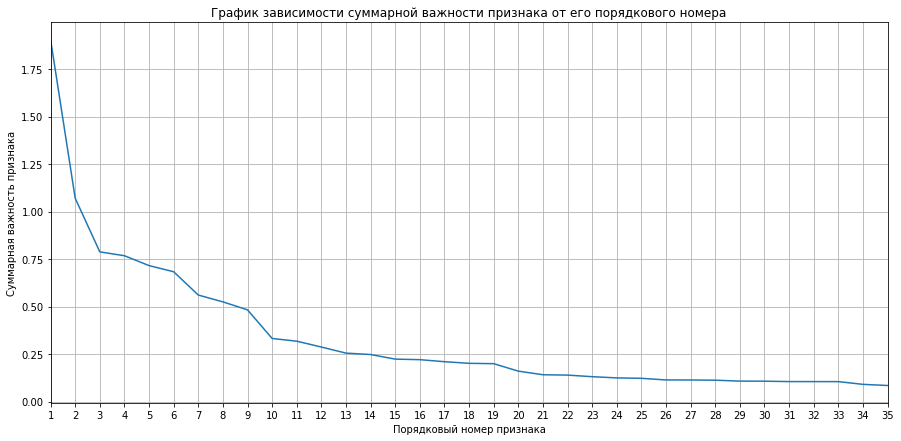

In [77]:
plt.subplots(figsize=(15, 7))
plt.plot([i for i in range(1,36)], results_features['Sum'])
plt.xticks([i for i in range(1,36)])
plt.xlim(1,35)
plt.grid()
plt.xlabel('Порядковый номер признака')
plt.ylabel('Суммарная важность признака')
plt.title('График зависимости суммарной важности признака от его порядкового номера')

In [83]:
for i in range(1, 36):
    evaluate_feature_selection_method(results_features.feature_name[:i].values, f'Top {i} features')

Method: Top 1 features
Decision Tree: 0.766
SVM: 0.766
RF: 0.766
Mean: 0.766
Save results into results_models dataframe
Method: Top 2 features
Decision Tree: 0.745
SVM: 0.766
RF: 0.753
Mean: 0.755
Save results into results_models dataframe
Method: Top 3 features
Decision Tree: 0.769
SVM: 0.767
RF: 0.806
Mean: 0.781
Save results into results_models dataframe
Method: Top 4 features
Decision Tree: 0.814
SVM: 0.791
RF: 0.843
Mean: 0.816
Save results into results_models dataframe
Method: Top 5 features
Decision Tree: 0.81
SVM: 0.798
RF: 0.847
Mean: 0.818
Save results into results_models dataframe
Method: Top 6 features
Decision Tree: 0.826
SVM: 0.802
RF: 0.844
Mean: 0.824
Save results into results_models dataframe
Method: Top 7 features
Decision Tree: 0.819
SVM: 0.805
RF: 0.856
Mean: 0.827
Save results into results_models dataframe
Method: Top 8 features
Decision Tree: 0.827
SVM: 0.838
RF: 0.865
Mean: 0.843
Save results into results_models dataframe
Method: Top 9 features
Decision Tree: 0.8

Список отобранных признаков:

In [87]:
results_features.feature_name[:15]

0            RatioBeyond2.5
1                       Std
2                  Kurtosis
3             SymmetricTest
4             HurstExponent
5                      Mean
6         MaxAutocorrCoeffs
7                      Skew
8                   HaarCD1
9        BenfordCorrelation
10        SumAutocorrCoeffs
11       ApproximateEntropy
12                  Entropy
13    RegularityTestSkewStd
14               BerkMethod
Name: feature_name, dtype: object